# Firm Entry and Exit (Clementi and Palazzo AEJ Macro 2016)

## Daniel Dimitrov

### 1. Recursive competitive equilibrium

1. Incumbent firms maximize value 

2. Free entry condition holds

3. Labor market clears

4. The measure of active firms $g^*(\epsilon, k)$ is stationary

### 2.  Solve for representative agent steady state

1. Households optimize according to: 
    
$$
L = E_0\sum_{t = 0}^{\infty} \beta^{t} (log(C_{t} + a n_{t}) - \lambda_t (C_{t} + (k_{t+1} - (1 - \delta) k_{t}) - w_{t} n_{t} - r_{t} k_{t})
$$

From the first order equations and the Euler equation, respectively, we get: 

$$
w_t \frac{1}{c_t} = a \tag{1}
$$
$$
\frac{1}{c_t} = \beta_t \frac{1}{c_{t+1}} (1+r_{t+1} - \delta) \tag{2}
$$

2. First optimize according to 

$$
\max_{K_{t}, N_{t}}{ \{ e^{z_{t}} K_{t}^{\theta} N_{t}^{\nu} - w_{t} N_{t} - K_{t} r_{r} \} }
$$

which leads to the first order conditions

$$
r_{t} = \theta e^{z_{t}} K_{t}^{\theta-1} N_{t}^{\nu} \tag{3}
$$

$$
w_{t} = \nu e^{z_{t}} K_{t}^\theta N_{t}^{\nu - 1} \tag{4}
$$

3. Market clearing and consistency

$$
z_{t+1} = \rho z_t + \epsilon_t \\
\epsilon_t \sim IIN(0,\sigma)
$$

$$
K_t = k_t \tag{5}
$$

$$
N_t = n_t \tag{6}
$$

We get the steady state by setting $z_t = E(z_t) = 0$, setting all other variables to their steady state time invariant values and solving equations (1) - (6)

In [96]:
import numpy as np
from scipy.stats import norm

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import quantecon as qn
from scipy import optimize


In [3]:
theta = 0.21
nu = 0.64
delta = 0.1
beta = 0.96
phi = 0.5
rho = 0.9
sigma = 0.02

Nbar = 0.6

#eq. 2
rbar = (1/beta) - (1 - delta)
#eq. 3 
Kbar = (rbar/(Nbar**(nu)*theta))**(1/(theta - 1))
#eq. 4 
wbar = nu*Kbar**(theta)*Nbar**(nu - 1)
#eq. 1 
cbar =wbar*Nbar + rbar*Kbar - Kbar + (1 - delta)*Kbar

print(rbar, Kbar, wbar, cbar)

0.14166666666666672 1.0881001887382777 0.7829715643830996 0.5151204464939546


### 3. Solve For Incumbent Firms’ Decision Rules

In [125]:
# set up the Tauchen discretization of the AR1

rho = 0.9
sigma = 0.02  #standard deviation of process error
Neps = 10 #number of points


def Tauchen(Neps, rho, sigma, m = 3):

    sigma_z = np.sqrt((sigma**2)/(1 - rho**2)) #Variance of AR(1)
    zmax = m*sigma_z
    zmin = - m*sigma_z
    z=[0]*Neps
    ztilde = [0]*(Neps-1)
    z[0] = zmin
    for i in range(1,Neps-1):
        z[i] = zmin + ((zmax - zmin)/(Neps-1))*(i)
    z[Neps-1] = zmax
    for i in range(Neps-1):
        ztilde[i] = (z[i+1] + z[i])/2
    pi = np.zeros([Neps, Neps])
    for i in range(Neps):
        for j in range(Neps):
            if j == 0:
                pi[i][j] = norm.cdf((ztilde[j] - rho*z[i])/sigma)
            elif j in range(1, Neps-1):
                pi[i][j] = norm.cdf((ztilde[j] - rho*z[i])/sigma) - norm.cdf((ztilde[j-1] - rho*z[i])/sigma)
            elif j == (Neps -1):
                pi[i][j] = 1 - norm.cdf((ztilde[j-1] - rho*z[i])/sigma)
    return z, pi




In [126]:
def n_fn(wbar, k, nu, epsilon, theta):
    # emplyment first order condition 
    n = (wbar/(nu*np.e**(epsilon)*k**(theta)))**(1/(nu-1))
    return n

def ValIter(params):
    # value iteration function 
    
    #unpack params
    varphi, theta, nu, delta, beta, phi, rho, sigma, cf, wstar = params
    #Set number of points for the shock grid. Used in the Tauchen Method
    Neps, Nk = 10, 100

    # Set bounds for captial
    k_low, k_high =  0.0000001, 3
    k_grid = np.linspace(k_low, k_high, Nk)
    #Get grid of shocks and their transition probabilities
    eps_grid, transition = Tauchen(Neps, rho, sigma, m = 3)
    # Now we initialize the value function by setting it to zero, two dimensional because two states
    V_old = np.zeros([Neps, Nk])  
    #Initialize the utility matrix
    obj, V1, V_new, policy = np.zeros_like(V_old),np.zeros_like(V_old),np.zeros_like(V_old),np.zeros_like(V_old)
    #Initialize the loop, set the convergence tolerance
    diff, counter, tol, = 10000, 0, 1e-9
    
    while (counter < 100 and diff > tol):
        for iK, k in enumerate(k_grid):
            #Compute n for objective function
            for jEps, epsilon in enumerate(eps_grid):
                # get optimal labor from FOC
                n = n_fn(wstar, k, nu, epsilon, theta)
                #Firm's objective function
                obj[jEps, :] = np.e**(epsilon)*k**(theta)*n**(nu) - wstar*n - \
                (k_grid-(1-delta)*k) - (varphi/2)*((k_grid/k) - (1 - delta))**(2)*k
            #Compute function to be maximized over all future k given current capital k_grid[i]
            actionvalue_allchoices = obj + beta * np.dot(transition, V_old)
            V1[:, iK] = np.max(actionvalue_allchoices, axis = 1)       
            max_indx = np.argmax(actionvalue_allchoices, axis = 1)
            policy[:, iK] = k_grid[max_indx]
            
        arg1 = np.ones([Neps,1])*(1-delta)*k_grid
        V_new = np.maximum(arg1, V1 - cf)
        policy[arg1 > V1 - cf] = 0
        difference = np.linalg.norm(V_new - V_old)**2
        V_old = V_new.copy()
        counter += 1
    indicator = np.zeros_like(policy)
    indicator[policy > 0] = 1
    
    #Now solve optimization problem deterimining firm entry
    #get the stationary (unconditional) distribution 
    mc = qn.MarkovChain(transition) 
    stat_probab = mc.stationary_distributions
    my_vec = -k_grid + beta*np.dot(stat_probab, V_new)
    V_E0 = np.max(my_vec)
    SV_E0 = np.sum(stat_probab*V_E0)
    
    
    return k_grid, eps_grid, V_new, policy, V_E0, SV_E0, transition, indicator

In [127]:
# Set up parameters and call value fn iteration
wstar = 0.78297
cf = 0.01
varphi = 0.5
theta = 0.21
nu = 0.64
delta = 0.1
beta = 0.96
phi = 0.5
rho = 0.9
sigma = 0.02
Nbar = 0.6

params = [varphi, theta, nu, delta, beta, phi, rho, sigma, cf, wstar]

k_grid, eps_grid, V_new, policy, V_E0, SV_E0, transition, indicator  = ValIter(params)



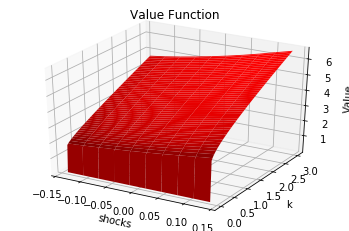

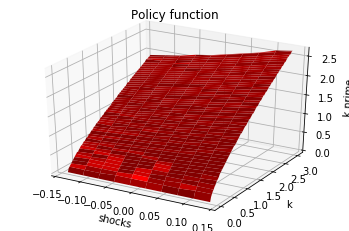

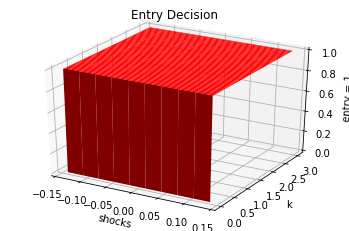

In [128]:
# Plot Value and Policy fn 
def value_fn_plot(k_grid, eps_grid,V_new, policy, indicator):
    k, eps = np.meshgrid(k_grid, eps_grid)

    fig = plt.figure()
    #plt.gcf().subplots_adjust(right = 1.1)
    ax1 = plt.axes(projection = "3d")
    ax1.plot_surface(eps, k, V_new, color='r')
    ax1.set_xlabel("shocks")
    ax1.set_ylabel("k")
    ax1.set_zlabel("Value")
    plt.title("Value Function")
    plt.show()


    fig = plt.figure()
    ax2 = plt.axes(projection = "3d")
    ax2.plot_surface(eps, k, policy, color='r')
    ax2.set_xlabel("shocks")
    ax2.set_ylabel("k")
    ax2.set_zlabel("k prime")
    plt.title("Policy function")
    plt.show()

    indicator = np.zeros_like(policy)
    indicator[policy > 0] = 1
    #Create indicator function for entry
    fig = plt.figure()
    ax3 = plt.axes(projection = "3d")
    ax3.plot_surface(eps, k, indicator, color='r')
    ax3.set_xlabel("shocks")
    ax3.set_ylabel("k")
    ax3.set_zlabel("entry = 1")
    plt.title("Entry Decision")
    plt.show()
    
value_fn_plot(k_grid, eps_grid,V_new, policy, indicator)

$\implies$ The continuation costs $c_f$  above are relatively small, so if your current capital value is large enough, it always makes sense to stay in the market regardless of what the shock value is. However, if we pump up the continuation costs, it turns out that for more native shocks it is better to exit

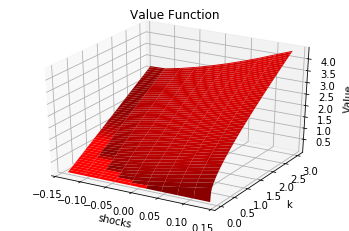

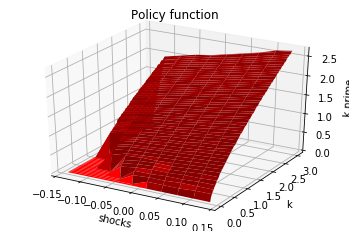

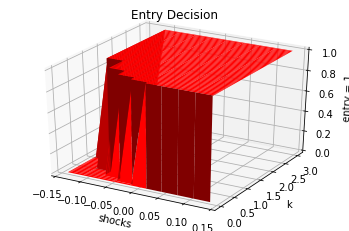

In [130]:
cf = 0.1

params = [varphi, theta, nu, delta, beta, phi, rho, sigma, cf, wstar]

k_grid, eps_grid, V_new, policy, V_E0, SV_E0, transition, indicator  = ValIter(params)

value_fn_plot(k_grid, eps_grid,V_new, policy, indicator)

### 4. Compute the market-clearing wage

In [131]:
cf = 0.01
F_params = [varphi, theta, nu, delta, beta, phi, rho, sigma, cf]

def F(w, F_params):
    ce = 0.02
    params = F_params.copy() + [w]
    k_grid, shocks, V_new, policyfun, V_E0, SV_E0, transition, indicator = ValIter(params)
    diff = SV_E0 - ce
    return diff

w_str = optimize.root(F, 0.6, F_params)
print('Equilibrium Wage is:', w_str.x)

Equilibrium Wage is: [1.35412507]


In [132]:
print(w_str)

    fjac: array([[-1.]])
     fun: 1.734723475976807e-17
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-3.29280006e-12])
       r: array([0.57629686])
  status: 1
 success: True
       x: array([1.35412507])
